In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
%load_ext autoreload
%autoreload 2

# IHDP

In [2]:
ihdp_train = np.load("data/IHDP/ihdp_npci_1-1000.train.npz")

In [3]:
ihdp_train.__dict__

{'_files': ['ate.npy',
  'mu1.npy',
  'mu0.npy',
  'yadd.npy',
  'yf.npy',
  'ycf.npy',
  't.npy',
  'x.npy',
  'ymul.npy'],
 'files': ['ate', 'mu1', 'mu0', 'yadd', 'yf', 'ycf', 't', 'x', 'ymul'],
 'allow_pickle': False,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='data/IHDP/ihdp_npci_1-1000.train.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x2aeb7332508>,
 'fid': <_io.BufferedReader name='data/IHDP/ihdp_npci_1-1000.train.npz'>}

In [4]:
for var in ihdp_train['x'][:,:,0].T:
    uniques = np.unique(var)
    if len(uniques) > 4:
        print("Num of unique vals: ", len(uniques))
    else:
        print("Unique vals: ",uniques)

Num of unique vals:  205
Num of unique vals:  43
Num of unique vals:  14
Unique vals:  [-0.87960599  0.16170253  1.20301104  2.24431956]
Num of unique vals:  85
Num of unique vals:  30
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [1. 2.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]


In [5]:
import copy
def transform_x_data(x_data):
    new_x_data = copy.deepcopy(x_data)
    #Transform the 4th variable into a categorical variable
    vals_4th_var = np.unique(x_data[:,3,:])
    val_to_idx = dict(zip(vals_4th_var, range(len(vals_4th_var))))
    vfunc = np.vectorize(lambda x: val_to_idx[x])
    new_x_data[:,3,:] = vfunc(new_x_data[:,3,:])
    
    #Transform 14th variable to regular {0,1} representation
    new_x_data[:,13,:] = new_x_data[:,13,:]-1
    
    return new_x_data
    
ihdp_x_train = transform_x_data(ihdp_train['x'])

In [6]:
#Check the result
for var in ihdp_x_train[:,:,0].T:
    uniques = np.unique(var)
    if len(uniques) > 4:
        print("Num of unique vals: ", len(uniques))
    else:
        print("Unique vals: ",uniques)

Num of unique vals:  205
Num of unique vals:  43
Num of unique vals:  14
Unique vals:  [0. 1. 2. 3.]
Num of unique vals:  85
Num of unique vals:  30
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]


## TODO: 
- create code that transforms the data in the necessary way ([1,2] to [0,1]), maybe the 4:th variable to categorical
- then to dataloader (should be ready)
- then train the model for multiple times (cross-validate somehow if we want to adjust hyperparamers or to early stopping?)
- What to do with the 1000 test sets? Statistics for the ATE errors etc.?
- Can try different z_dim parameters also
- Should the test set be a validation or real test set (evaluating the final performance (of what?))
    - Should the "true" ATE be calculated with the entire data set or just the test set? After all, it is a population level quantity that we are trying to estimate
    - Probably for ITE inference and error we do need the test set separately
    - E.g. gen.bounds paper: For each simulated yf and ycf set, do train/validation/test split and average the final results (again, focusing on ITE inference)
- Out-of-sample and within-sample ATE errors?? -> based on ITE scores estimated out-of-sample and within-sample. Seems a bit misguided since the point of ATE is to be a population-level metric.
    - Can't we just estimate the true ATE (and p(y|do(t))) with the yf and ycf values and see how close we get with the VAE (for data where only one of yf or ycf is shown)
        - We could maybe also check out the data generating process to get the actual true values
        - Why is that not done with the any of the papers? Do they want to really simulate a somewhat real scenario for some reason? (even ITE inference could be done like this for IHDP)

In [7]:
(ihdp_train['mu1'] - ihdp_train['mu0']).mean()

4.402550421661204

In [8]:
ihdp_train['t'].sum() / np.product(ihdp_train['t'].shape)

0.1859672619047619

In [9]:
print("Covariate shape: ", ihdp_train['x'].shape)
print("Factual outcome shape: ", ihdp_train['yf'].shape)
print("mu1 shape: ", ihdp_train['mu1'].shape)

Covariate shape:  (672, 25, 1000)
Factual outcome shape:  (672, 1000)
mu1 shape:  (672, 1000)


- What is the meaning of the 1000 "simulations"? Can we train the model 1000 times?
- mu1, mu0 vs. yf and ycf?
- What are yadd, ymul?

# Jobs

In [45]:
jobs_train = np.load("data/Jobs/jobs_DW_bin.new.10.train.npz")

In [46]:
jobs_train.__dict__

{'_files': ['ate.npy',
  'e.npy',
  'I.npy',
  'yadd.npy',
  'yf.npy',
  't.npy',
  'x.npy',
  'ymul.npy'],
 'files': ['ate', 'e', 'I', 'yadd', 'yf', 't', 'x', 'ymul'],
 'allow_pickle': False,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='data/Jobs/jobs_DW_bin.new.10.train.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x1746eaae208>,
 'fid': <_io.BufferedReader name='data/Jobs/jobs_DW_bin.new.10.train.npz'>}

In [52]:
jobs_train['x']
for i in range(17):
    print(jobs_train['x'][:5,i,:])

[[ 1.07934372  1.36161469  1.36161469  1.36161469  1.64388566  1.36161469
   1.36161469  1.36161469  1.64388566  1.64388566]
 [-0.42610144  1.64388566  1.64388566  1.64388566 -0.42610144  1.64388566
   1.64388566  1.64388566  1.07934372  1.07934372]
 [ 2.02024695  1.07934372  1.07934372  1.07934372  2.11433728  1.07934372
  -0.42610144  1.07934372 -0.42610144 -0.42610144]
 [ 2.11433728 -0.42610144  2.02024695 -0.42610144 -0.70837241 -0.42610144
   2.02024695 -0.42610144  2.02024695  2.02024695]
 [ 1.36161469  2.02024695  2.11433728  2.02024695  1.07934372  2.11433728
   2.11433728  1.36161469 -0.70837241  2.11433728]]
[[0.10183499 0.10183499 0.10183499 0.10183499 0.10183499 0.10183499
  0.10183499 0.10183499 0.10183499 0.10183499]
 [0.10183499 0.10183499 0.10183499 0.10183499 0.10183499 0.10183499
  0.10183499 0.10183499 0.10183499 0.10183499]
 [0.10183499 0.10183499 0.10183499 0.10183499 0.10183499 0.10183499
  0.10183499 0.10183499 0.10183499 0.10183499]
 [0.10183499 0.10183499 0.101

In [72]:
print("Dim of yf: ", jobs_train['yf'].shape)
print("Dim of t: ", jobs_train['t'].shape)
print("Dim of x: ", jobs_train['x'].shape)

Dim of yf:  (2570, 10)
Dim of t:  (2570, 10)
Dim of x:  (2570, 17, 10)


In [73]:
print("Dim of e: ", jobs_train['e'].shape)
print("Dim of I: ", jobs_train['I'].shape)

Dim of e:  (2570, 10)
Dim of I:  (2570, 10)


- What are the dimensions in 'yf', for example? 10? Is it the exact same data with different train/test splits?
- What are 'e' and 'I'?

# Running CEVAE on IHDP data

In [7]:
df = pd.DataFrame(np.concatenate([ihdp_x_train[:,:,0], ihdp_train['t'][:,0][:,None], ihdp_train['yf'][:,0][:,None]],1),
                 columns = ["x"+str(i) for i in range(ihdp_x_train.shape[1])] + ["t", "y"])
dataset = CEVAEDataset(df)
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [9]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.01
lr_end=0.0005
x_dim=ihdp_x_train.shape[1]
z_dim=10
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)

Epoch 0:
Epoch loss: 15191.541870117188
x: 12459.752807617188, t: 358.1520824432373, y: 2204.164878845215, kld: 169.471848487854
Epoch 1:
Epoch loss: 13436.167236328125
x: 11640.525085449219, t: 329.84455490112305, y: 1410.2693328857422, kld: 55.528345346450806
Epoch 2:
Epoch loss: 13242.340393066406
x: 11371.4677734375, t: 318.7197847366333, y: 1349.0144348144531, kld: 203.13836359977722
Epoch 3:
Epoch loss: 13054.379638671875
x: 10999.958557128906, t: 326.08712673187256, y: 1318.5005531311035, kld: 409.8332748413086
Epoch 4:
Epoch loss: 12823.22998046875
x: 10814.686309814453, t: 324.71553897857666, y: 1258.8050804138184, kld: 425.02294540405273
Epoch 5:
Epoch loss: 12953.812744140625
x: 10909.236145019531, t: 327.48541927337646, y: 1249.060001373291, kld: 468.0311965942383
Epoch 6:
Epoch loss: 12786.831420898438
x: 10701.854675292969, t: 322.00145149230957, y: 1219.649917602539, kld: 543.3256034851074
Epoch 7:
Epoch loss: 12730.601867675781
x: 10555.175415039062, t: 322.406832695007

Epoch loss: 11668.942138671875
x: 8758.723937988281, t: 315.77029037475586, y: 1006.471004486084, kld: 1587.976905822754
Epoch 64:
Epoch loss: 11744.589111328125
x: 8829.085021972656, t: 311.88444900512695, y: 1012.9009399414062, kld: 1590.718864440918
Epoch 65:
Epoch loss: 11696.844421386719
x: 8779.851959228516, t: 312.4188985824585, y: 1010.0295181274414, kld: 1594.5440139770508
Epoch 66:
Epoch loss: 11645.062133789062
x: 8783.625793457031, t: 314.02238178253174, y: 982.5425071716309, kld: 1564.8714981079102
Epoch 67:
Epoch loss: 11697.401947021484
x: 8763.52896118164, t: 313.62967681884766, y: 999.5667686462402, kld: 1620.676658630371
Epoch 68:
Epoch loss: 11707.974914550781
x: 8798.040069580078, t: 314.7777919769287, y: 996.2853622436523, kld: 1598.8717803955078
Epoch 69:
Epoch loss: 11569.127746582031
x: 8710.654235839844, t: 312.72361278533936, y: 992.9157638549805, kld: 1552.8341751098633
Epoch 70:
Epoch loss: 11675.922912597656
x: 8794.666290283203, t: 310.11988258361816, y: 9

Epoch loss: 10990.228302001953
x: 7387.710845947266, t: 299.66397285461426, y: 958.448558807373, kld: 2344.4048767089844
Epoch 127:
Epoch loss: 10997.030548095703
x: 7399.5826416015625, t: 304.0868248939514, y: 968.7763442993164, kld: 2324.584541320801
Epoch 128:
Epoch loss: 10982.85043334961
x: 7398.976257324219, t: 297.2214756011963, y: 971.494743347168, kld: 2315.157928466797
Epoch 129:
Epoch loss: 10974.526977539062
x: 7341.3184814453125, t: 300.9665780067444, y: 976.4880638122559, kld: 2355.753761291504
Epoch 130:
Epoch loss: 11002.173736572266
x: 7349.243988037109, t: 299.4607172012329, y: 965.8990707397461, kld: 2387.5700149536133
Epoch 131:
Epoch loss: 10953.689697265625
x: 7300.299774169922, t: 293.55889225006104, y: 952.8744697570801, kld: 2406.95654296875
Epoch 132:
Epoch loss: 10951.508819580078
x: 7345.054595947266, t: 301.9537944793701, y: 975.09130859375, kld: 2329.409248352051
Epoch 133:
Epoch loss: 10907.90902709961
x: 7295.752197265625, t: 302.4190068244934, y: 968.88

Epoch loss: 10788.03482055664
x: 7059.693511962891, t: 295.4524784088135, y: 952.3898086547852, kld: 2480.4990463256836
Epoch 190:
Epoch loss: 10894.806701660156
x: 7194.398498535156, t: 294.860294342041, y: 960.0854606628418, kld: 2445.462471008301
Epoch 191:
Epoch loss: 10890.28466796875
x: 7104.858428955078, t: 292.6409387588501, y: 971.8330421447754, kld: 2520.952423095703
Epoch 192:
Epoch loss: 10780.262878417969
x: 7022.561187744141, t: 289.5677824020386, y: 961.0909423828125, kld: 2507.042953491211
Epoch 193:
Epoch loss: 10871.343658447266
x: 7146.1512451171875, t: 291.9502353668213, y: 946.2550659179688, kld: 2486.987091064453
Epoch 194:
Epoch loss: 10869.81430053711
x: 7122.579376220703, t: 296.5170192718506, y: 955.7474021911621, kld: 2494.9706420898438
Epoch 195:
Epoch loss: 10857.109344482422
x: 7095.334625244141, t: 295.5520353317261, y: 962.9726524353027, kld: 2503.2498168945312
Epoch 196:
Epoch loss: 10873.033905029297
x: 7124.811553955078, t: 296.9970655441284, y: 961.3

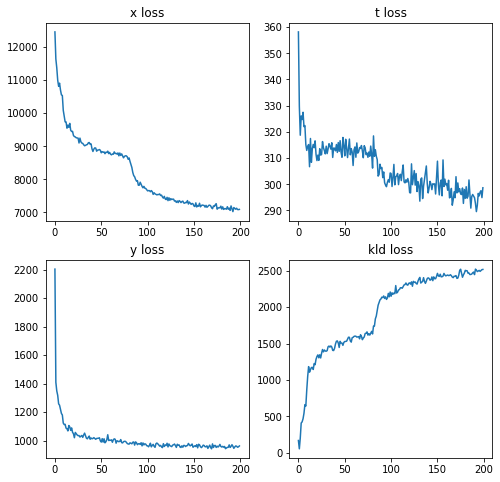

In [10]:
model, losses = train_model(device, plot_curves, print_logs,
              dataloader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=False)

In [141]:
Ey_dot = estimate_model_py_dot(model,n=10000)
print(Ey_dot)
Ey_dot[1] - Ey_dot[0]

[2.40804458 6.28388834]


3.8758437633514404

In [12]:
#True values ~ sort of?
print(ihdp_train['mu1'][:,0].mean())
print(ihdp_train['mu0'][:,0].mean())
print(ihdp_train['mu1'][:,0].mean() - ihdp_train['mu0'][:,0].mean())

6.45146795987858
2.43701736968941
4.0144505901891705


In [178]:
#Estimate based on factual outcomes
sim_run = 0
yfdata = ihdp_train['yf'][:,sim_run]
tdata = ihdp_train['t'][:,sim_run]
print((yfdata*tdata).sum()/(tdata==1).sum())
print((yfdata*(1-tdata)).sum()/(tdata==0).sum())
print((yfdata*tdata).sum()/(tdata==1).sum()-(yfdata*(1-tdata)).sum()/(tdata==0).sum())

6.46072872494169
2.393144606697551
4.06758411824414


In [123]:
ihdp_train['yf'][ihdp_train['t']==1]

array([ 4.77123234,  6.65992586,  3.74822257, ..., 10.41272884,
        9.48914554,  8.75471345])

In [132]:
ITE = np.zeros(ihdp_train['yf'].shape)
ITE = (ihdp_train['yf'] - ihdp_train['ycf'])*ihdp_train['t'] + (ihdp_train['ycf'] - ihdp_train['yf'])*(1-ihdp_train['t'])

In [182]:
ITE[:,0].mean()

4.033316926957236

In [194]:
ihdp_train['t'][:,10].mean()

0.18452380952380953

## Notes
- Doesn't quite get the right result, but close
- What if we use the extra simulation draws to mimic larger data sets to see how the p(y|do(t)) function gets closer to the real thing? <- won't work
- We get a pretty good E[y|do(t)] result with only the factual outcomes...
    - What's the point of ATE errors in previous articles?
        - To measure the overall bias resulted from using the estimator for ITE inference?
        - Should I be doing the ITE inference as well? => not necessarily, if we focus on the population level quantities like in effect restoration papers. Could argue that it's the most plausible usecase for CEVAE and necessary for correct ITE inference
- Why do the mean values of yf vary so much between simulation runs? Were they sampled somehow differently?
    - The data generating process is sampled like in Hill 2011, https://github.com/vdorie/npci/tree/master/examples/ihdp_sim has code that does that
    - I could generate new yf:s (and ycf:s) and get the true ATE:s and true ITE:s directly. Again, why isn't it done like that in the ML papers?
- Do we want sample ATE estimates or population estimates? The natural thing for effect restoration is population level estimates, but as mentioned in the Hill paper, usually that's not done if we assume ignorability, because the sample might not be randomly selected from the population and the population ATE is not that useful anyways.
    - So, for other papers the out-of-sample and within-sample ATE errors can make sense, but not necessarily with CEVAE
    - Especially non-parametric causal inference tends to focus on sample estimates because population estimates are difficult
- What can we even do with this data set if population level quantities are not necessarily not plausible to compute?
    - Would need to do ITE inference after all for sample estimates
    - Maybe could just forget that and assume X are randomly sampled? => get the "true" effect with that assumption

# Kysymyksiä
- Miten näitä "oikeita" datasettejä voi käyttää identifioinnin tutkimiseen?
    - Ajamalla mallin vain kerran täydelle datasetille?
    - Vai voiko jotenkin tehdä esim. (otoskoko, ATE-virhe) -plotin, josta näkisi jonkinlaisen konvergoitumisen?
- Otosestimaatit vai populaatioestimaatit?
    - Otosestimaatteja voi tehdä ITE-estimaateilla
    - Mutta siihen tarvitaan CEVAE:lla oletus, että malli estimoi koko populaation todennäköisyysjakauman
        - Populaatio-ATE siis siinä mielessä oleellisempi kuin otos-ATE